In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

!ls '/content/drive/MyDrive/Bert/data'

Mounted at /content/drive/
doi-song  khoa-hoc    oto-xe-may  suc-khoe	     the-thao
du-lich   kinh-doanh  phap-luat   text_features.pkl
giao-duc  label.pkl   so-hoa	  text.pkl


In [ ]:
!pip3 install underthesea
!pip3 install fairseq
!pip3 install fastbpe

     |████████████████████████████████| 7.5 MB 4.7 MB/s 
     |████████████████████████████████| 3.4 MB 46.0 MB/s 
     |████████████████████████████████| 235 kB 45.0 MB/s 
     |████████████████████████████████| 743 kB 43.0 MB/s 
     |████████████████████████████████| 43 kB 1.7 MB/s 
     |████████████████████████████████| 61 kB 474 kB/s 
     |████████████████████████████████| 596 kB 39.0 MB/s 
     |████████████████████████████████| 895 kB 41.3 MB/s 
     |████████████████████████████████| 3.3 MB 42.3 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=de4cd11e7dfe843b9bea83754c6759aabb16fbcff998c98adc1b13b77791b670
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.7 MB 5

  Created wheel for fastbpe: filename=fastBPE-0.1.0-cp37-cp37m-linux_x86_64.whl size=483106 sha256=36c987a780c69fd965b23f333a8aac8e13dd660600d52dc4ced54be89b525eb6
  Stored in directory: /root/.cache/pip/wheels/bd/d4/0e/0d317a65f77d3f8049fedd8a2ee0519164cf3e6bd77ef886f1
Successfully built fastbpe


In [ ]:
import torch

from fairseq.models.roberta import RobertaModel
from fairseq.data.encoders.fastbpe import fastBPE

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models

import underthesea as uts

import glob2
import numpy as np
from tqdm.notebook import tqdm

import re

import pickle
import string
import io

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def save_pkl(path, obj):
  with open(path, 'wb') as f:
    pickle.dump(obj, f)

def load_pkl(path):
  with open(path, 'rb') as f:
    obj = pickle.load(f)
  return obj

In [ ]:
stopwords = []
with open('/content/drive/MyDrive/Bert/stopwords.txt', mode='r', encoding='utf-8') as f:
  for line in enumerate(f):
    stopwords.append(str(line[1]).strip())
stopwords[:5]

['a lô', 'a ha', 'ai', 'ai ai', 'ai nấy']

In [ ]:
path = '/content/drive/MyDrive/Bert/data/*/*.txt'

def load_and_preprocess_data(path):
    texts = []
    labels = []
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    for file_path in tqdm(glob2.glob(path), desc='Read file'):
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = f.read()

            data = data.replace('“', ' ').replace('”', ' ')
            data = (regex.sub(' ', str(data))).lower()

            data = uts.word_tokenize(data, format='text')

            data = ' '.join([word for word in data.split() if word not in stopwords])

            label = file_path.split('/')[6]
            texts.append(data)
            labels.append(label)
        except:
            next
    return texts, labels

In [ ]:
text, label = load_and_preprocess_data('/content/drive/MyDrive/Bert/data/*/*.txt')

Read file:   0%|          | 0/10000 [00:00<?, ?it/s]

# **ONLY run the block below in the FIRST time !!!**

In [ ]:
save_pkl('/content/drive/MyDrive/Bert/data/text.pkl', text)
save_pkl('/content/drive/MyDrive/Bert/data/label.pkl', label)

# **ONLY run the block below for the SECOND time onwards !!!**

In [ ]:
text = load_pkl('/content/drive/MyDrive/Bert/data/text.pkl')
label = load_pkl('/content/drive/MyDrive/Bert/data/label.pkl')

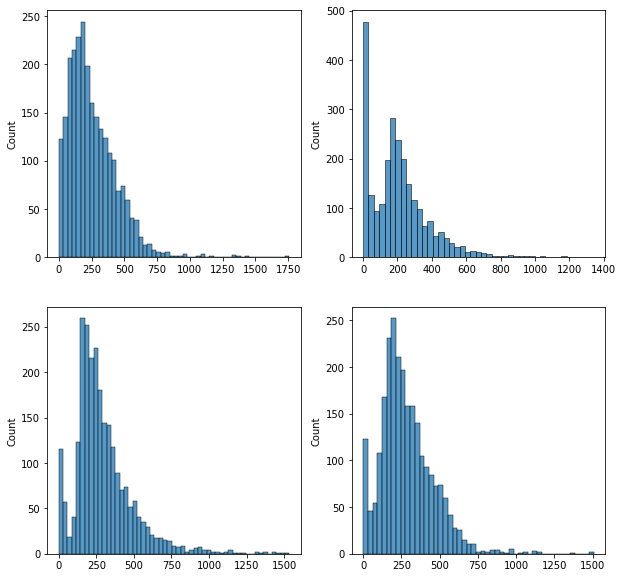

In [ ]:
figure, axis = plt.subplots(2, 2, figsize=(10, 10))

text_len = [len(i.split()) for i in text[:2500]]
sns.histplot(text_len, ax=axis[0, 0])

text_len = [len(i.split()) for i in text[2500:5000]]
sns.histplot(text_len, ax=axis[1, 0])

text_len = [len(i.split()) for i in text[5000:7500]]
sns.histplot(text_len, ax=axis[0, 1])

text_len = [len(i.split()) for i in text[7500:]]
sns.histplot(text_len, ax=axis[1, 1])

plt.show()

In [ ]:
phobert = RobertaModel.from_pretrained('/content/drive/MyDrive/Bert/PhoBERT_base_fairseq', checkpoint_file='model.pt')
phobert.eval()

1042301B [00:00, 4947519.58B/s]
456318B [00:00, 4539977.35B/s]


RobertaHubInterface(
  (model): RobertaModel(
    (encoder): RobertaEncoder(
      (sentence_encoder): TransformerSentenceEncoder(
        (dropout_module): FairseqDropout()
        (embed_tokens): Embedding(64001, 768, padding_idx=1)
        (embed_positions): LearnedPositionalEmbedding(258, 768, padding_idx=1)
        (layers): ModuleList(
          (0): TransformerSentenceEncoderLayer(
            (dropout_module): FairseqDropout()
            (activation_dropout_module): FairseqDropout()
            (self_attn): MultiheadAttention(
              (dropout_module): FairseqDropout()
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=T

In [ ]:
class BPE():
    bpe_codes = '/content/drive/MyDrive/Bert/PhoBERT_base_fairseq/bpe.codes'

args = BPE()
phobert.bpe = fastBPE(args)

In [ ]:
MAX_LEN = 256
def feature_extraction(data):

    outputs = []

    for i, d in tqdm(enumerate(data), total=len(data)):
        input_ids = phobert.encode(d).long().tolist()

        if len(input_ids) > MAX_LEN:
            input_ids = input_ids[:MAX_LEN]
            input_ids[-1] = 2  #truncate
        else:
            input_ids = input_ids + [1, ] * (MAX_LEN - len(input_ids))  #padding

        input_ids = torch.tensor([input_ids])
        last_layer_features = phobert.extract_features(input_ids)

        outputs.append(np.ravel(last_layer_features[:, 0, :].detach().numpy()))

    return outputs

In [ ]:
text_features = feature_extraction(text)

  0%|          | 0/10000 [00:00<?, ?it/s]

# **ONLY run the block below in the FIRST time !!!**

In [ ]:
save_pkl('/content/drive/MyDrive/Bert/data/text_features.pkl', text_features)

# **ONLY run the block below for the SECOND time onwards !!!**

In [ ]:
text_features = load_pkl('/content/drive/MyDrive/Bert/data/text_features.pkl')
label = load_pkl('/content/drive/MyDrive/Bert/data/label.pkl')

In [ ]:
label[:5]

['phap-luat', 'phap-luat', 'phap-luat', 'phap-luat', 'phap-luat']

In [ ]:
text_features[0]

array([-6.64633512e-01,  6.08061194e-01, -2.94787079e-01, -8.78853798e-01,
       -8.74021575e-02,  4.57739264e-01,  3.18061829e-01, -5.26020288e-01,
       -1.75772801e-01,  2.34328195e-01,  7.26083517e-02, -1.52747855e-01,
       -8.59599710e-02,  3.99281293e-01, -3.12956162e-02,  5.60898244e-01,
       -1.34216398e-01, -3.21620375e-01, -3.04441631e-01,  1.14464611e-01,
        5.04376590e-01, -1.17346001e+00,  7.41763934e-02,  1.47321716e-01,
       -1.27521574e-01,  5.00810407e-02,  1.90301150e-01,  5.50266132e-02,
        6.54117018e-02,  6.25840902e-01, -3.02806888e-02, -1.95524246e-01,
        5.07519305e-01, -2.18051285e-01,  3.53910178e-01, -2.22734779e-01,
       -4.00508672e-01, -4.10585925e-02,  2.52472490e-01,  1.16303392e-01,
        2.80851513e-01, -3.19556862e-01,  3.07668507e-01, -3.13361913e-01,
        2.56148696e-01,  7.58872256e-02,  4.37690109e-01,  8.26780796e-02,
        5.39974809e-01,  5.29991210e-01,  3.55969854e-02, -3.98119017e-02,
        3.31357837e-01, -

In [ ]:
lb = LabelEncoder()
lb.fit(label)
label = lb.fit_transform(label)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(text_features, label, test_size = .2, shuffle = True, stratify=label)

In [ ]:
label

array([6, 6, 6, ..., 2, 2, 2])

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
knn_label_predict = knn.predict(X_test)

In [ ]:
knn_label_predict[0:5]

array([0, 6, 8, 4, 2])

In [ ]:
from sklearn.metrics import mean_squared_error


acc_knn = knn.score(X_test, y_test)*100
mse_knn = mean_squared_error(y_test, knn_label_predict)
rmse_knn = mean_squared_error(y_test, knn_label_predict,squared = False)

print('Accuracy with KNN: ',acc_knn,'%')
print('Mean squared error with KNN: ',mse_knn)
print('Root mean squared error with KNN: ',rmse_knn)

Accuracy with KNN:  88.44999999999999 %
Mean squared error with KNN:  1.8345
Root mean squared error with KNN:  1.354437152473307


In [ ]:
svm = SVC(kernel='linear', probability=True, gamma=0.125)
svm.fit(X_train, y_train)

SVC(gamma=0.125, kernel='linear', probability=True)

In [ ]:
svm_label_predict = svm.predict(X_test)

In [ ]:
acc_svm = svm.score(X_test, y_test)*100
mse_svm = mean_squared_error(y_test, svm_label_predict)
rmse_svm = mean_squared_error(y_test, svm_label_predict,squared = False)

print('Accuracy with SVM: ',acc_svm,'%')
print('Mean squared error with SVM: ',mse_svm)
print('Root mean squared error with SVM: ',rmse_svm)

Accuracy with SVM:  89.60000000000001 %
Mean squared error with SVM:  1.6025
Root mean squared error with SVM:  1.2658988901172163


In [ ]:
X_train = tf.stack(X_train)
y_train = tf.stack(y_train)

X_test = tf.stack(X_test)
y_test = tf.stack(y_test)

In [ ]:
cnn = models.Sequential()
cnn.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(768,1)))
cnn.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
cnn.add(layers.Dropout(0.5))
cnn.add(layers.MaxPooling1D(pool_size=2))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(100, activation='relu'))
cnn.add(layers.Dense(10, activation='sigmoid'))

cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 766, 64)           256       
                                                                 
 conv1d_5 (Conv1D)           (None, 764, 64)           12352     
                                                                 
 dropout_2 (Dropout)         (None, 764, 64)           0         
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 382, 64)          0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 24448)             0         
                                                                 
 dense_4 (Dense)             (None, 100)               2444900   
                                                      

In [ ]:
cnn.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
X_train = tf.stack(X_train)
y_train = tf.stack(y_train)

X_test = tf.stack(X_test)
y_test = tf.stack(y_test)

In [ ]:
history = cnn.fit(X_train, y_train, epochs=15,validation_data=(X_test, y_test),)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


250/250 [==============================] - 30s 117ms/step - loss: 0.6374 - accuracy: 0.7909 - val_loss: 0.4266 - val_accuracy: 0.8615
Epoch 2/15
250/250 [==============================] - 29s 116ms/step - loss: 0.2827 - accuracy: 0.9051 - val_loss: 0.3720 - val_accuracy: 0.8785
Epoch 3/15
250/250 [==============================] - 29s 116ms/step - loss: 0.2175 - accuracy: 0.9274 - val_loss: 0.2998 - val_accuracy: 0.9040
Epoch 4/15
250/250 [==============================] - 29s 116ms/step - loss: 0.1698 - accuracy: 0.9385 - val_loss: 0.3158 - val_accuracy: 0.9090
Epoch 5/15
250/250 [==============================] - 29s 116ms/step - loss: 0.1398 - accuracy: 0.9507 - val_loss: 0.3621 - val_accuracy: 0.8940
Epoch 6/15
250/250 [==============================] - 29s 116ms/step - loss: 0.1079 - accuracy: 0.9610 - val_loss: 0.3272 - val_accuracy: 0.9045
Epoch 7/15
250/250 [==============================] - 29s 117ms/step - loss: 0.0866 - accuracy: 0.9705 - val_loss: 0.3793 - val_accuracy: 0.8

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

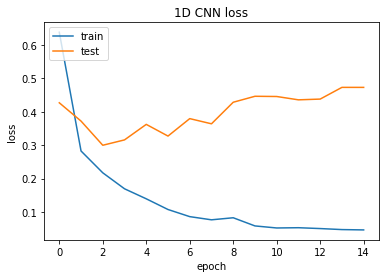

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('1D CNN loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

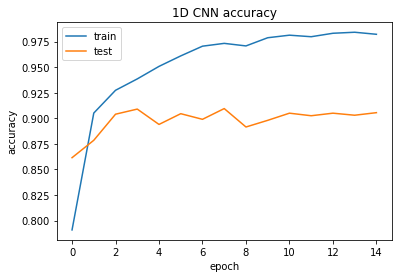

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('1D CNN accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
cnn_predict = cnn.predict(X_test)

In [ ]:
cnn_label_predict = []
for i in cnn_predict:
  cnn_label_predict.append(np.argmax(i))

In [ ]:
mse = tf.keras.metrics.MeanSquaredError()
rmse = tf.keras.metrics.RootMeanSquaredError()
acc = tf.keras.metrics.Accuracy()

In [ ]:
acc_1dcnn = acc(y_test, cnn_label_predict).numpy()*100
mse_1dcnn = mse(y_test, cnn_label_predict).numpy()
rmse_1dcnn = rmse(y_test, cnn_label_predict).numpy()

print('Accuracy with 1D CNN: ',acc_1dcnn,'%')
print('Mean squared error with 1D CNN: ',mse_1dcnn)
print('Root mean squared error with 1D CNN: ',rmse_1dcnn)

Accuracy with 1D CNN:  90.49999713897705 %
Mean squared error with 1D CNN:  1.6795
Root mean squared error with 1D CNN:  1.2959552


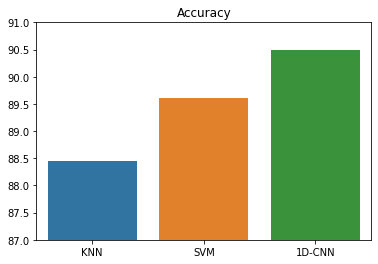

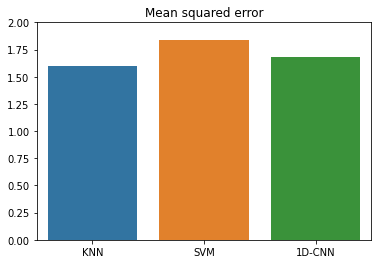

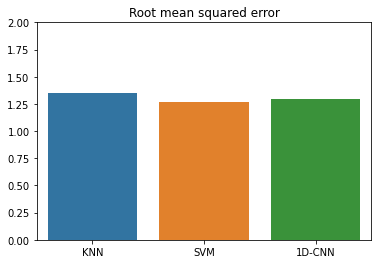

In [ ]:
plot_label = ['KNN','SVM','1D-CNN']

acc_val = [acc_knn,acc_svm,acc_1dcnn]
acc_min = int(min(acc_val))-1
acc_max = int(max(acc_val))+1

acc_plot = sns.barplot(x=plot_label,y= acc_val)
acc_plot.set_title('Accuracy')
acc_plot.set(ylim=(acc_min,acc_max))
plt.show()

mse_val = [mse_svm,mse_knn,mse_1dcnn]
mse_min = int(min(mse_val))-1
mse_max = int(max(mse_val))+1

mse_plot = sns.barplot(x=plot_label,y= mse_val)
mse_plot.set_title('Mean squared error')
mse_plot.set(ylim=(mse_min,mse_max))
plt.show()

rmse_val = [rmse_knn,rmse_svm,rmse_1dcnn]
rmse_min = int(min(rmse_val))-1
rmse_max = int(max(rmse_val))+1

rmse_plot = sns.barplot(x=plot_label,y= rmse_val)
rmse_plot.set_title('Root mean squared error')
rmse_plot.set(ylim=(rmse_min,rmse_max))
plt.show()